In [1]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparapy as sp
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
# %matplotlib ipympl
from sparapy import io

Fast radiosity using manual input

In [2]:
# Define parameters
X = 3
Y = 3
Z = 3
patch_size = 0.5
ir_length_s = 2
sampling_rate = 1000
max_order_k = 150
speed_of_sound = 346.18
absorption = 0.1

# create geometry

walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [2, 2, 2]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [1, 1, 1]

start = datetime.now()

# create object
radiosity_fast = sp.DRadiosityFast.from_polygon(walls, patch_size)

# create directional scattering data (totally diffuse)
sources = pf.Coordinates(0, 0, 1)
receivers = pf.Coordinates(0, 0, 1)
frequencies = np.array([500])
data_scattering = pf.FrequencyData(
    np.ones((sources.csize, receivers.csize, frequencies.size)), frequencies)

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)

# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))

# calculate from factors including directivity and absorption
radiosity_fast.bake_geometry(algorithm='order')

# initialize source energy at each patch
radiosity_fast.init_source_energy(source_pos, algorithm='order')

# gather energy at receiver
ir_fast = radiosity_fast.calculate_energy_exchange_receiver(
    receiver_pos, speed_of_sound=speed_of_sound,
    histogram_time_resolution=1/sampling_rate, histogram_length=ir_length_s,
    algorithm='order', max_depth=max_order_k)
manual = pf.Signal(ir_fast, sampling_rate=sampling_rate)

# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

C:\Users\Anindita I. Hapsari\AppData\Local\Temp\ipykernel_6900\941856824.py:32: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_scattering(


Time elapsed: 0:01:00.314382


Fast radiosity using read_geometry function (stl file)

In [4]:
# Define parameters
patch_size = 0.5
ir_length_s = 2
sampling_rate = 1000
max_order_k = 150
speed_of_sound = 346.18
absorption = 0.1

# create geometry

path = 'shoebox_3.stl'
walls = io.read_geometry(path,'rectangle')
source_pos = [2, 2, 2]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [1, 1, 1]

start = datetime.now()

# create object
radiosity_fast = sp.DRadiosityFast.from_polygon(walls, patch_size)

# create directional scattering data (totally diffuse)
sources = pf.Coordinates(0, 0, 1)
receivers = pf.Coordinates(0, 0, 1)
frequencies = np.array([500])
data_scattering = pf.FrequencyData(
    np.ones((sources.csize, receivers.csize, frequencies.size)), frequencies)

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)

# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))

# calculate from factors including directivity and absorption
radiosity_fast.bake_geometry(algorithm='order')

# initialize source energy at each patch
radiosity_fast.init_source_energy(source_pos, algorithm='order')

# gather energy at receiver
ir_fast = radiosity_fast.calculate_energy_exchange_receiver(
    receiver_pos, speed_of_sound=speed_of_sound,
    histogram_time_resolution=1/sampling_rate, histogram_length=ir_length_s,
    algorithm='order', max_depth=max_order_k)
rectangles = pf.Signal(ir_fast, sampling_rate=sampling_rate)

# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

Number of vertices: 8
Number of triangular faces: 12


C:\Users\Anindita I. Hapsari\AppData\Local\Temp\ipykernel_6900\3614360381.py:30: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_scattering(


Time elapsed: 0:00:33.031714


Plot comparison

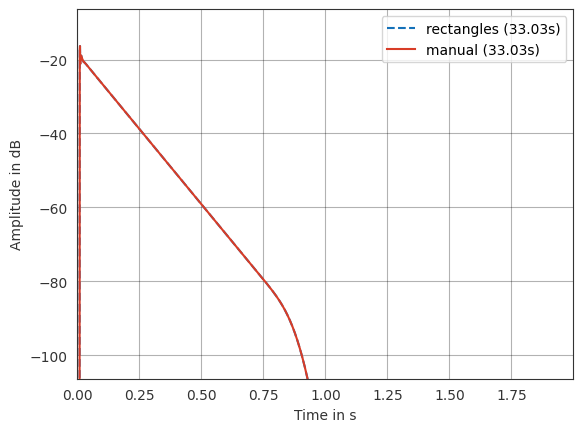

In [5]:
plt.figure()

pf.plot.time(
    rectangles, dB=True, log_prefix=10,
    label=f'rectangles ({fast_time_s:0.2f}s)',
    linestyle='--')

pf.plot.time(
    manual, dB=True, log_prefix=10,
    label=f'manual ({fast_time_s:0.2f}s)',
    linestyle='-')

plt.legend()
plt.show()